In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
%matplotlib inline
# %matplotlib qt
# %matplotlib osx
import numpy as np
import cmocean
import itertools
from mpl_toolkits.basemap import Basemap
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from adjustText import adjust_text

sns.set_style("whitegrid")
sns.set_style("ticks")
from datetime import datetime
str(datetime.now())

# sns.set_palette('colorblind')


'2019-09-13 12:11:18.502350'

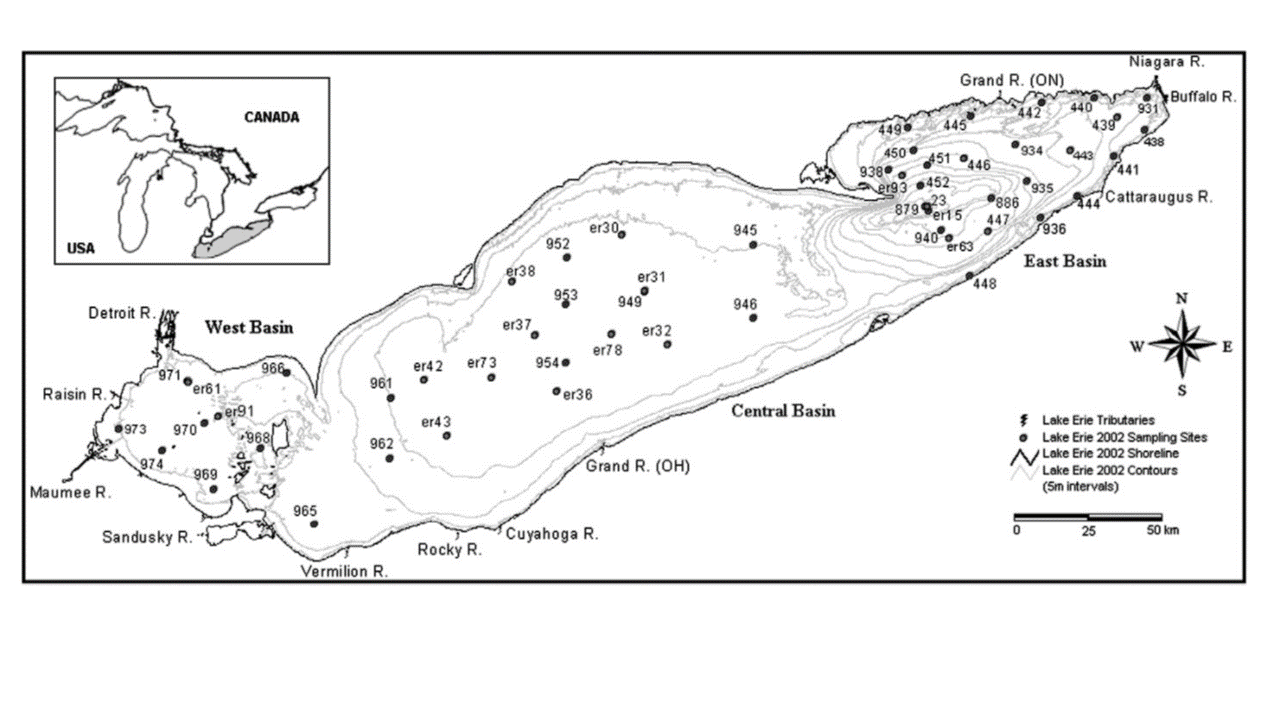

In [3]:
from IPython.display import Image
Image(filename='/Users/imarkelo/git/Great-Lakes-Data/measurements/ECCC/Lake_Erie_map_with_stations-1.png') 

In [4]:
df = pd.read_excel('../../measurements/ECCC/LakeErie_Markelov_Dove26May2017.xlsx', sheetname='Data')
ECCCmeas = df[df['DEPTH_TO']==0]
ECCCmeas['YEAR']=pd.to_datetime(pd.DatetimeIndex(ECCCmeas['STN_DATE'])).year
ECCCmeas['MONTH']=pd.to_datetime(pd.DatetimeIndex(ECCCmeas['STN_DATE'])).month
ECCCmeas = ECCCmeas[ECCCmeas['YEAR']>1999]
# Cl = Cl[Cl.QC_TYPE=='routine field sample']
# Cl = Cl[~Cl.DEPTH_CODE.isin(['Integrated, Spring', 'Integrated, Summer'])]
# Cl = Cl[Cl.YEAR>2002]
# Cl.loc[:,'SAMPLE_DEPTH_M'] *= -1

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [5]:
eastern_basin_a = [448, 940, 879, 938, 450, 449, 451, 452, 447, 936,886,446, 445,934,935,444,441,443,442,440,439,438,931]
central_basin_a = [965, 962, 961, 954, 953, 952, 949, 945, 946]
western_basin_a = [971, 973, 974, 970, 966, 968, 969]

In [6]:
eastern_basin_b = [937,939,941,942,887,1237,1236,933,727,932, 486, 67]
central_basin_b = [493,492,491,338,885,311,339,341,963,964,960,859,918,919,957,958,1326,880,920,956,955,899,915,889,888,916,951,950,896,897,898,1053,948,947,1223,1222,1221,1220,1219,1218,1217,1216,1215,1214,1213,1212,1211,1210,1209,1292,943,944,947,205,1048]
western_basin_b = [882, 733, 881, 1156, 972, 343, 357, 358, 344, 337, 967, 494, 495, 496]


In [7]:
western_basin_f = list(filter(lambda x: x in  western_basin_a + western_basin_b, ECCCmeas.groupby(['PSN']).count().sort_values('CRUISE_PLAN', ascending=False).index))
central_basin_f = list(filter(lambda x: x in  central_basin_a + central_basin_b, ECCCmeas.groupby(['PSN']).count().sort_values('CRUISE_PLAN', ascending=False).index))
eastern_basin_f = list(filter(lambda x: x in  eastern_basin_a + eastern_basin_b, ECCCmeas.groupby(['PSN']).count().sort_values('CRUISE_PLAN', ascending=False).index))


In [8]:
western_basin_f[:6]

[970, 881, 969, 973, 967, 968]

In [9]:
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)

def season(x):
    if x in spring:
       return 'Spring'
    if x in summer:
       return 'Summer'
    if x in fall:
       return 'Fall'
    else:
       return 'Winter'

In [10]:
ECCCmeas['SEASON'] = pd.to_datetime(pd.DatetimeIndex(ECCCmeas['STN_DATE'])).dayofyear.map(season)

In [11]:
ECCCmeas.loc[:,'DEPTH_FROM'] *= -1

In [12]:
ECCCmeas = ECCCmeas[ECCCmeas['DEPTH_FROM']>-900]

In [13]:
ECCCmeas['VALUE'] = pd.to_numeric(ECCCmeas['VALUE'], errors='coerce')
ECCCmeas['PSN'] = pd.to_numeric(ECCCmeas['PSN'], errors='coerce')
ECCCmeas['LATITUDE_DD'] = pd.to_numeric(ECCCmeas['LATITUDE_DD'], errors='coerce')
ECCCmeas['LONGITUDE_DD'] = pd.to_numeric(ECCCmeas['LONGITUDE_DD'], errors='coerce')

In [14]:
stations = eastern_basin_f + central_basin_f + western_basin_f
years = range(2003,2018)
seasons = ['Spring', 'Summer']

In [15]:
ECCCmeas.ABBREV.unique()

array(['PH', 'D ORG C', 'POC', 'D 02 W', 'SAT 02', 'TP', 'SR P', 'TF P',
       'N TP', 'NH3', 'NO3NO2 F', 'S04 F', 'CL F', 'CA FA', 'MG F',
       'K-FAAS', 'NA-FAAS', 'D OXY P', 'CAU', 'CAC', 'AL/T-OES',
       'FE/T-OES', 'SO4', 'CL-F', 'AL/T-MS', 'FE/T-MS', 'D.I.C', 'F-F',
       'SO4-F', 'SRP-P-F', 'TP-P', 'TP-P-UF', 'TP-P-F', 'CA-F', 'K-F',
       'MG-F', 'NA-F'], dtype=object)

In [16]:
ECCCmeas.FULL_NAME.unique()

array(['PH', 'CARBON,DISSOLVED ORGANIC', 'CARBON,PARTICULATE ORGANIC',
       'OXYGEN,CONCENTRATION DISSOLVED', 'OXYGEN,% SAT. DISSOLVED',
       'PHOSPHOROUS,TOTAL', 'PHOSPHOROUS,SOLUBLE REACTIVE,FILTERED',
       'PHOSPHORUS,TOTAL FILTERED', 'NITROGEN,TOTAL PARTICULATE',
       'AMMONIA NITROGEN,SOLUBLE', 'NITRATE+NITRITE NITROGEN,FILTERED',
       'SULPHATE,FILTERED.', 'CHLORIDE,FILTERED',
       'CALCIUM,FILTERED ATOMIC ABS.', 'MAGNESIUM,FILTERED',
       'POTASSIUM-F.,ATOMIC ABSORPTION', 'SODIUM-F.,ATOMIC ABSORPTION',
       'DISSOLVED OXYGEN, PROFILER WQP', 'CHLOROPHYL A, UNCORRECTED',
       'CHLOROPHYLL A, CORRECTED PHAEOPHYTIN',
       'ALUMINUM                      ', 'IRON                          ',
       'SULPHATE', 'CHLORIDE', 'ALUMINUM', 'IRON',
       'DISSOLVED INORGANIC CARBON', 'FLUORIDE',
       'AMMONIA NITROGEN, SOLUBLE', 'NITRATE+NITRITE NITROGEN, FILTERED',
       'SOLUBLE REACTIVE PHOSPHOROUS', 'PHOSPHORUS, TOTAL, PARTICULATE',
       'TOTAL PHOSPHOROUS', 'TOT

In [17]:
# ECCCmeas = ECCCmeas[ECCCmeas['PSN'].isin(eastern_basin + central_basin + western_basin)]
ECCCmeas = ECCCmeas[ECCCmeas['SEASON'].isin(seasons)]
# ECCCmeas['VALUE'] = pd.to_numeric(ECCCmeas['VALUE'], errors='coerce')

In [18]:
ECCCmeas[~ECCCmeas['PSN'].isin(eastern_basin_f + central_basin_f + western_basin_f)].PSN.unique()

array([ 959,  980, 1163, 1238, 1239, 1240, 1257, 1207, 1262])

In [19]:
PSNs_loc = ECCCmeas.groupby(['PSN']).mean()[['LATITUDE_DD', 'LONGITUDE_DD']].reset_index()


In [20]:
nc = Dataset('../../measurements/bathymetry/erie_lld.grd')
topo = -nc.variables['z'][:] #[::10,::10]
x = nc.variables['x'][:] #[::10]
y = nc.variables['y'][:] #[::10]
lon, lat = np.meshgrid(x, y)

In [21]:
levels1 = np.linspace(0,70,14*2+1)

In [22]:
Cl = pd.read_csv('../../measurements/GLNPO/Mass Balance/Cl.csv')

In [23]:
GLENDA_stations = Cl.groupby(['STATION_ID']).mean()[['LATITUDE', 'LONGITUDE']].reset_index()

In [24]:
GLENDA_stations['LATITUDE'] = pd.to_numeric(GLENDA_stations['LATITUDE'], errors='coerce')
GLENDA_stations['LONGITUDE'] = pd.to_numeric(GLENDA_stations['LONGITUDE'], errors='coerce')

In [25]:
glenda_eastern_basin = ['ER15M', 'ER09', 'ER63', 'ER10']
glenda_central_basin = ['ER78M', 'ER38', 'ER37', 'ER42', 'ER30', 'ER73', 'ER36', 'ER32'] #, 'ER43','ER31']
glenda_western_basin = ['ER58', 'ER59', 'ER61', 'ER60', 'ER92', 'ER91M']

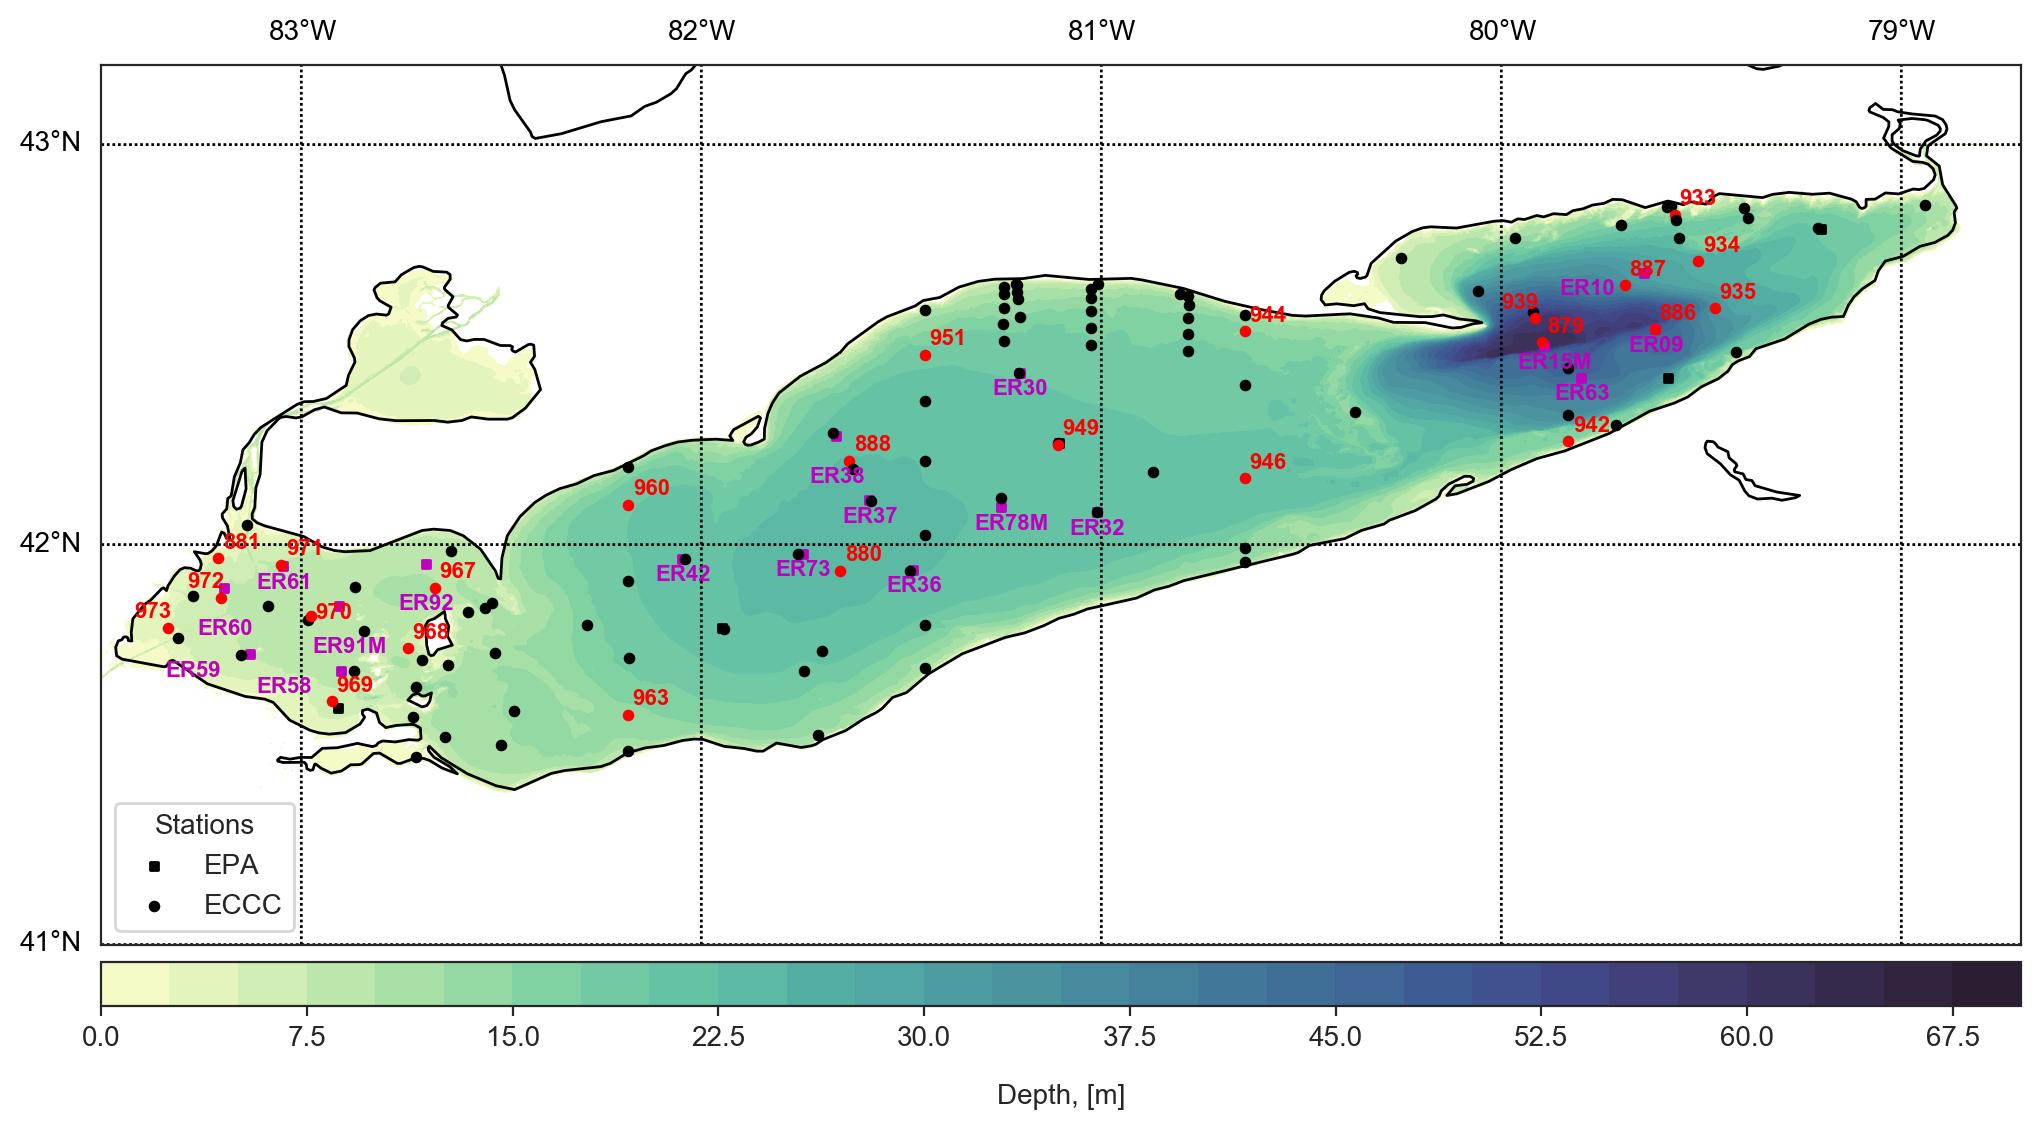

In [26]:
# %matplotlib qt
f=plt.figure(figsize=(12,6), dpi=200)

m = Basemap(llcrnrlon=-83.5,llcrnrlat=41,urcrnrlon=-78.7,urcrnrlat=43.2, resolution='h',projection='cyl',lat_0=42.0+0.2,lon_0=-81.0-0.2)
# m = Basemap(projection='cyl', lat_0=42.0+0.2,lon_0=-81.0-0.2)
x, y = m(lon, lat)
m.drawcoastlines()
m.drawparallels(np.arange(41., 44, 1.),labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-84., -78., 1.),labels=[0,0,1,0], fontsize=10)
# plt.contour(x,y,topo, levels=levels1, colors='k')  # negative contours will be dashed by default
cax = m.contourf(x,y,topo, levels=levels1,cmap=cmocean.cm.deep)
cbar = m.colorbar(cax,location='bottom')
texts = []
for i,row in GLENDA_stations.iterrows():
    if row['STATION_ID'] in glenda_eastern_basin+glenda_central_basin + glenda_western_basin:
        plt.scatter(row['LONGITUDE'], row['LATITUDE'], color='m', s=10, marker='s')
        texts.append(plt.text(row['LONGITUDE']-0.07, row['LATITUDE']-0.07, '{}'.format(row['STATION_ID']), fontsize=8, color='m', weight='bold'))
    else:
        a1=plt.scatter(row['LONGITUDE'], row['LATITUDE'], color='k', s=10, marker='s')
#         plt.text(row['LONGITUDE']+0.01, row['LATITUDE']+0.01, '{}'.format(row['STATION_ID']), fontsize=8, color='k')
for i,row in PSNs_loc.iterrows():
    if row['PSN'] in western_basin_f[:8]+central_basin_f[:8] + eastern_basin_f[:8]:
        plt.scatter(row['LONGITUDE_DD'], row['LATITUDE_DD'], color='r', s=10)
        texts.append(plt.text(row['LONGITUDE_DD']+0.01, row['LATITUDE_DD']+0.01, '{0:.0f}'.format(row['PSN']), fontsize=8, color='r', weight='bold'))
    else:
        a2=plt.scatter(row['LONGITUDE_DD'], row['LATITUDE_DD'], color='k', s=10)

        #         plt.text(row['LONGITUDE_DD']+0.01, row['LATITUDE_DD']+0.01, '{0:.0f}'.format(row['PSN']), fontsize=4, color='k')

adjust_text(texts)
plt.legend([a1,a2], ['EPA','ECCC'], title='Stations')
plt.text(0.5,-0.18,'Depth, [m]', horizontalalignment='center', transform=f.axes[0].transAxes)
# plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
# f.savefig('Mass Balance/GLENDA/All Stations/map_stations.pdf') 


In [27]:
ECCCmeas.ABBREV.unique()

array(['PH', 'D ORG C', 'POC', 'D 02 W', 'SAT 02', 'TP', 'SR P', 'TF P',
       'N TP', 'NH3', 'NO3NO2 F', 'S04 F', 'CL F', 'CA FA', 'MG F',
       'K-FAAS', 'NA-FAAS', 'D OXY P', 'CAU', 'CAC', 'AL/T-OES',
       'FE/T-OES', 'SO4', 'CL-F', 'AL/T-MS', 'FE/T-MS', 'D.I.C', 'F-F',
       'SO4-F', 'SRP-P-F', 'TP-P', 'TP-P-UF', 'TP-P-F', 'CA-F', 'K-F',
       'MG-F', 'NA-F'], dtype=object)

In [28]:
combined_elements = [['PH'], ['CAU', 'CAC'], ['D.I.C'], ['D ORG C'], ['POC'], ['D 02 W', 'D OXY P'],['TP-P-UF', 'TP'], ['TP-P-F', 'TF P'], ['SRP-P-F', 'SR P'], 
 ['N TP'], ['NH3'], ['NO3NO2 F'], ['SO4-F', 'S04 F'], ['CL-F', 'CL F'], ['CA-F', 'CA-F/ICP', 'CA FA'], 
 ['MG-F', 'MG F', 'MG-F'], ['K FS', 'K-FAAS','K-FICP','K-F'], ['NA FS', 'NA-FAAS', 'NA-FICP', 'NA-F'],
 ['AL/T-OES', 'AL/T-MS'], ['FE/T-OES', 'FE/T-MS'], ['F-F'], ['SAT 02']]

 
 

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/U

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core

No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/U

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value 

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core

/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
/Users/imarkelo/anaconda3/envs/phd/lib/python3.6/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/U

KeyboardInterrupt: 

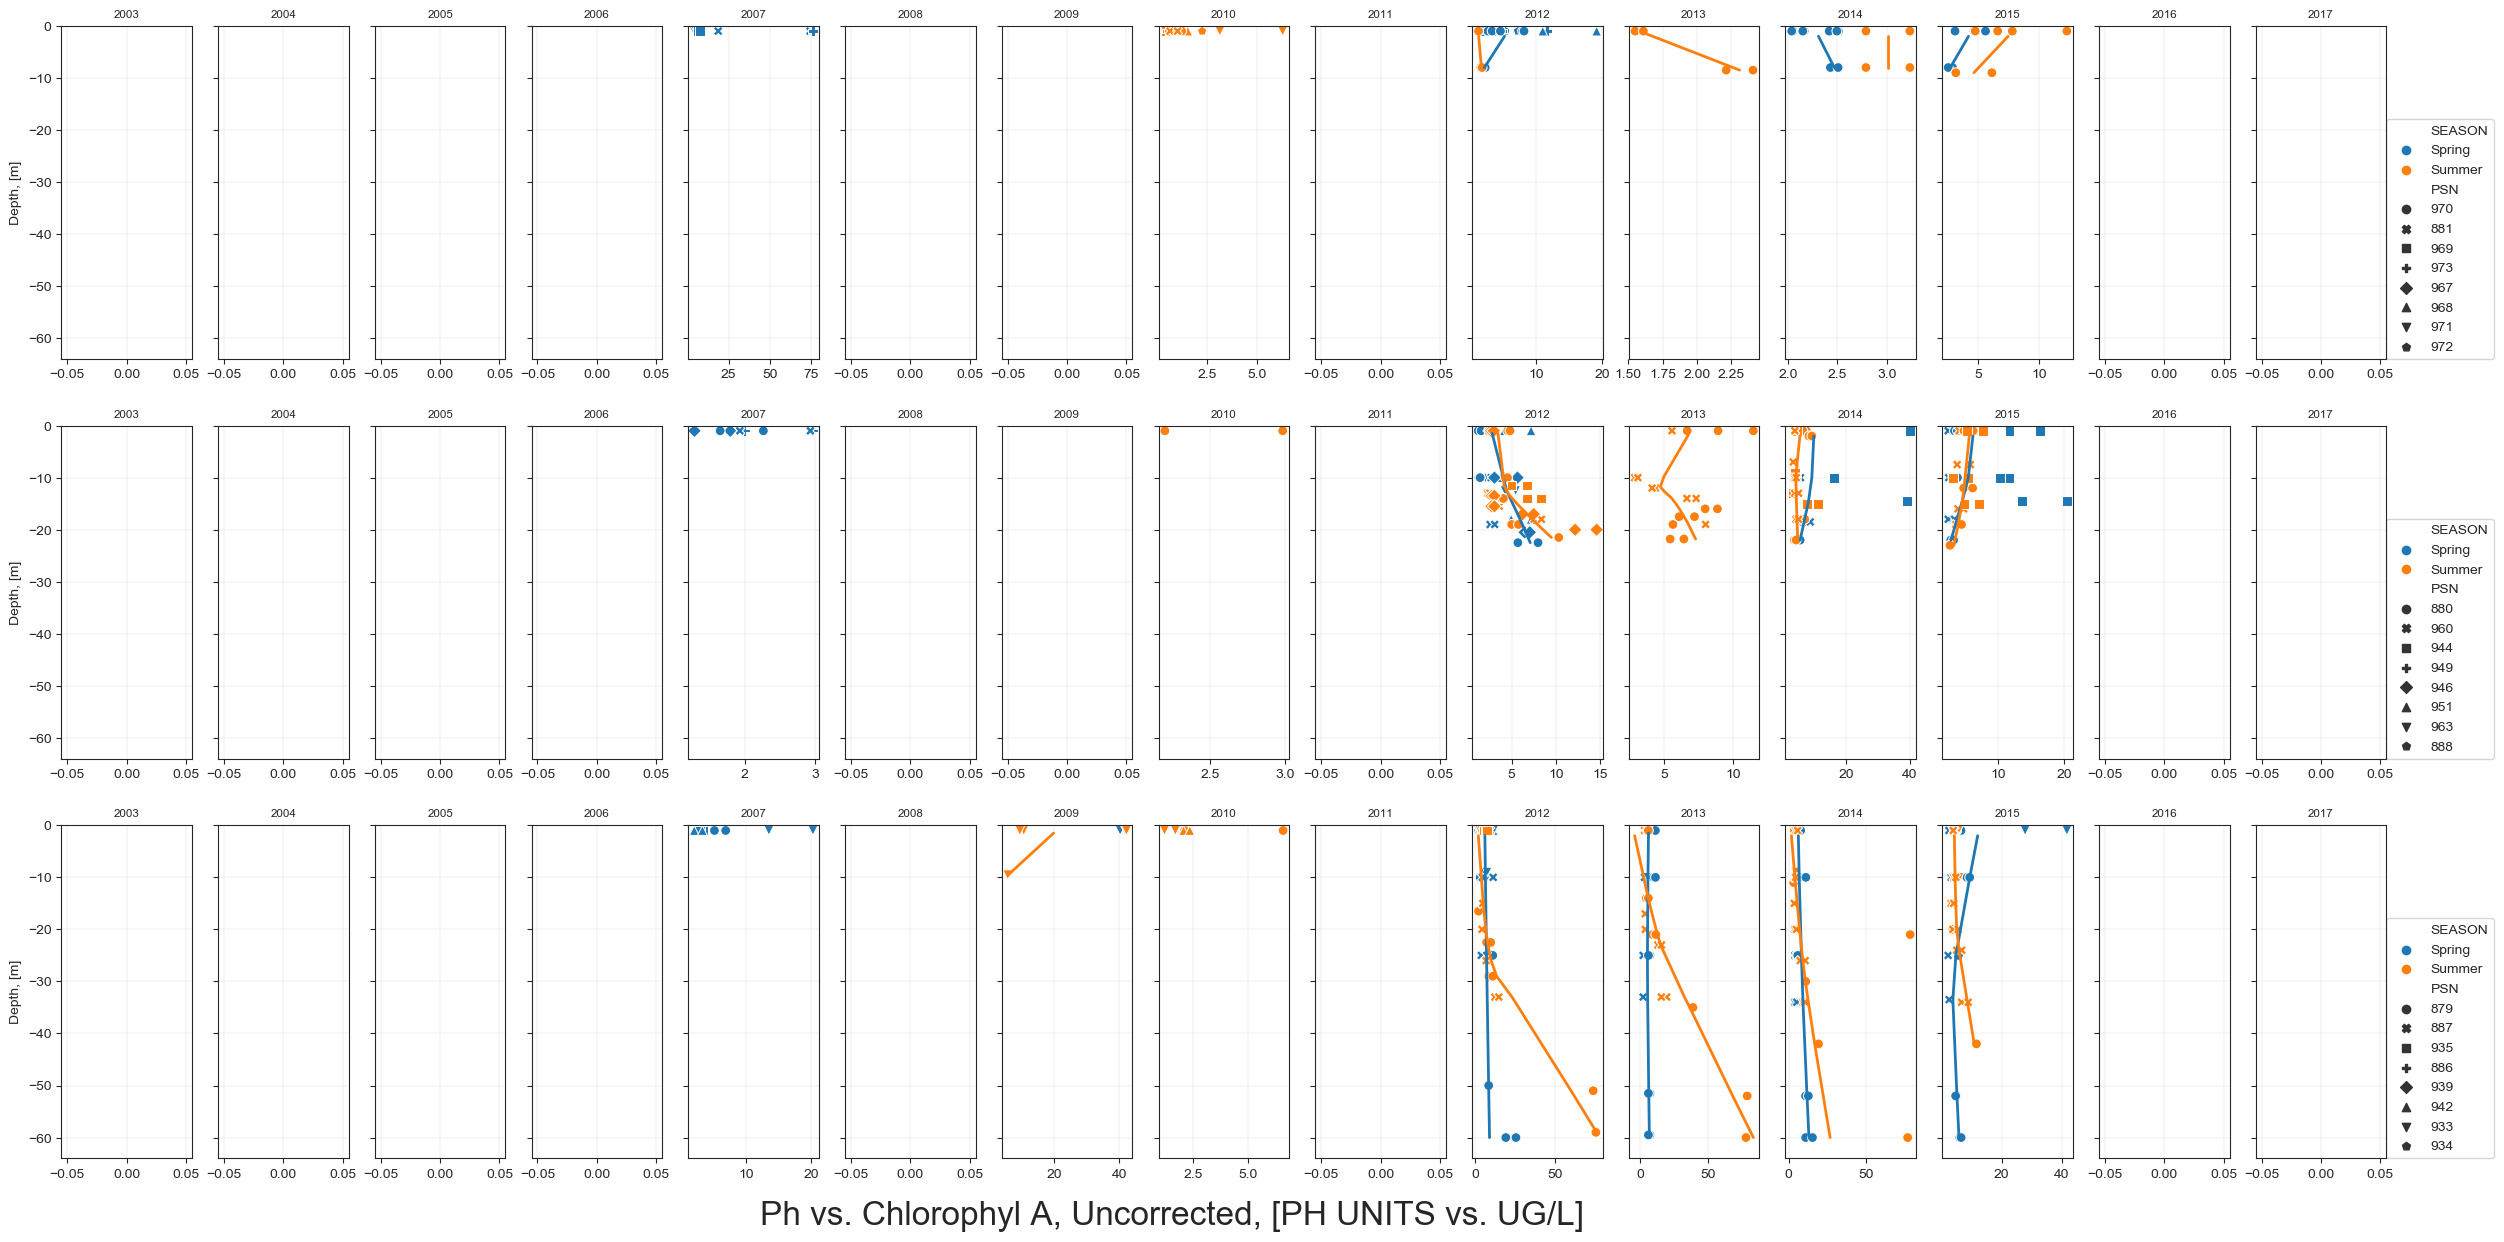

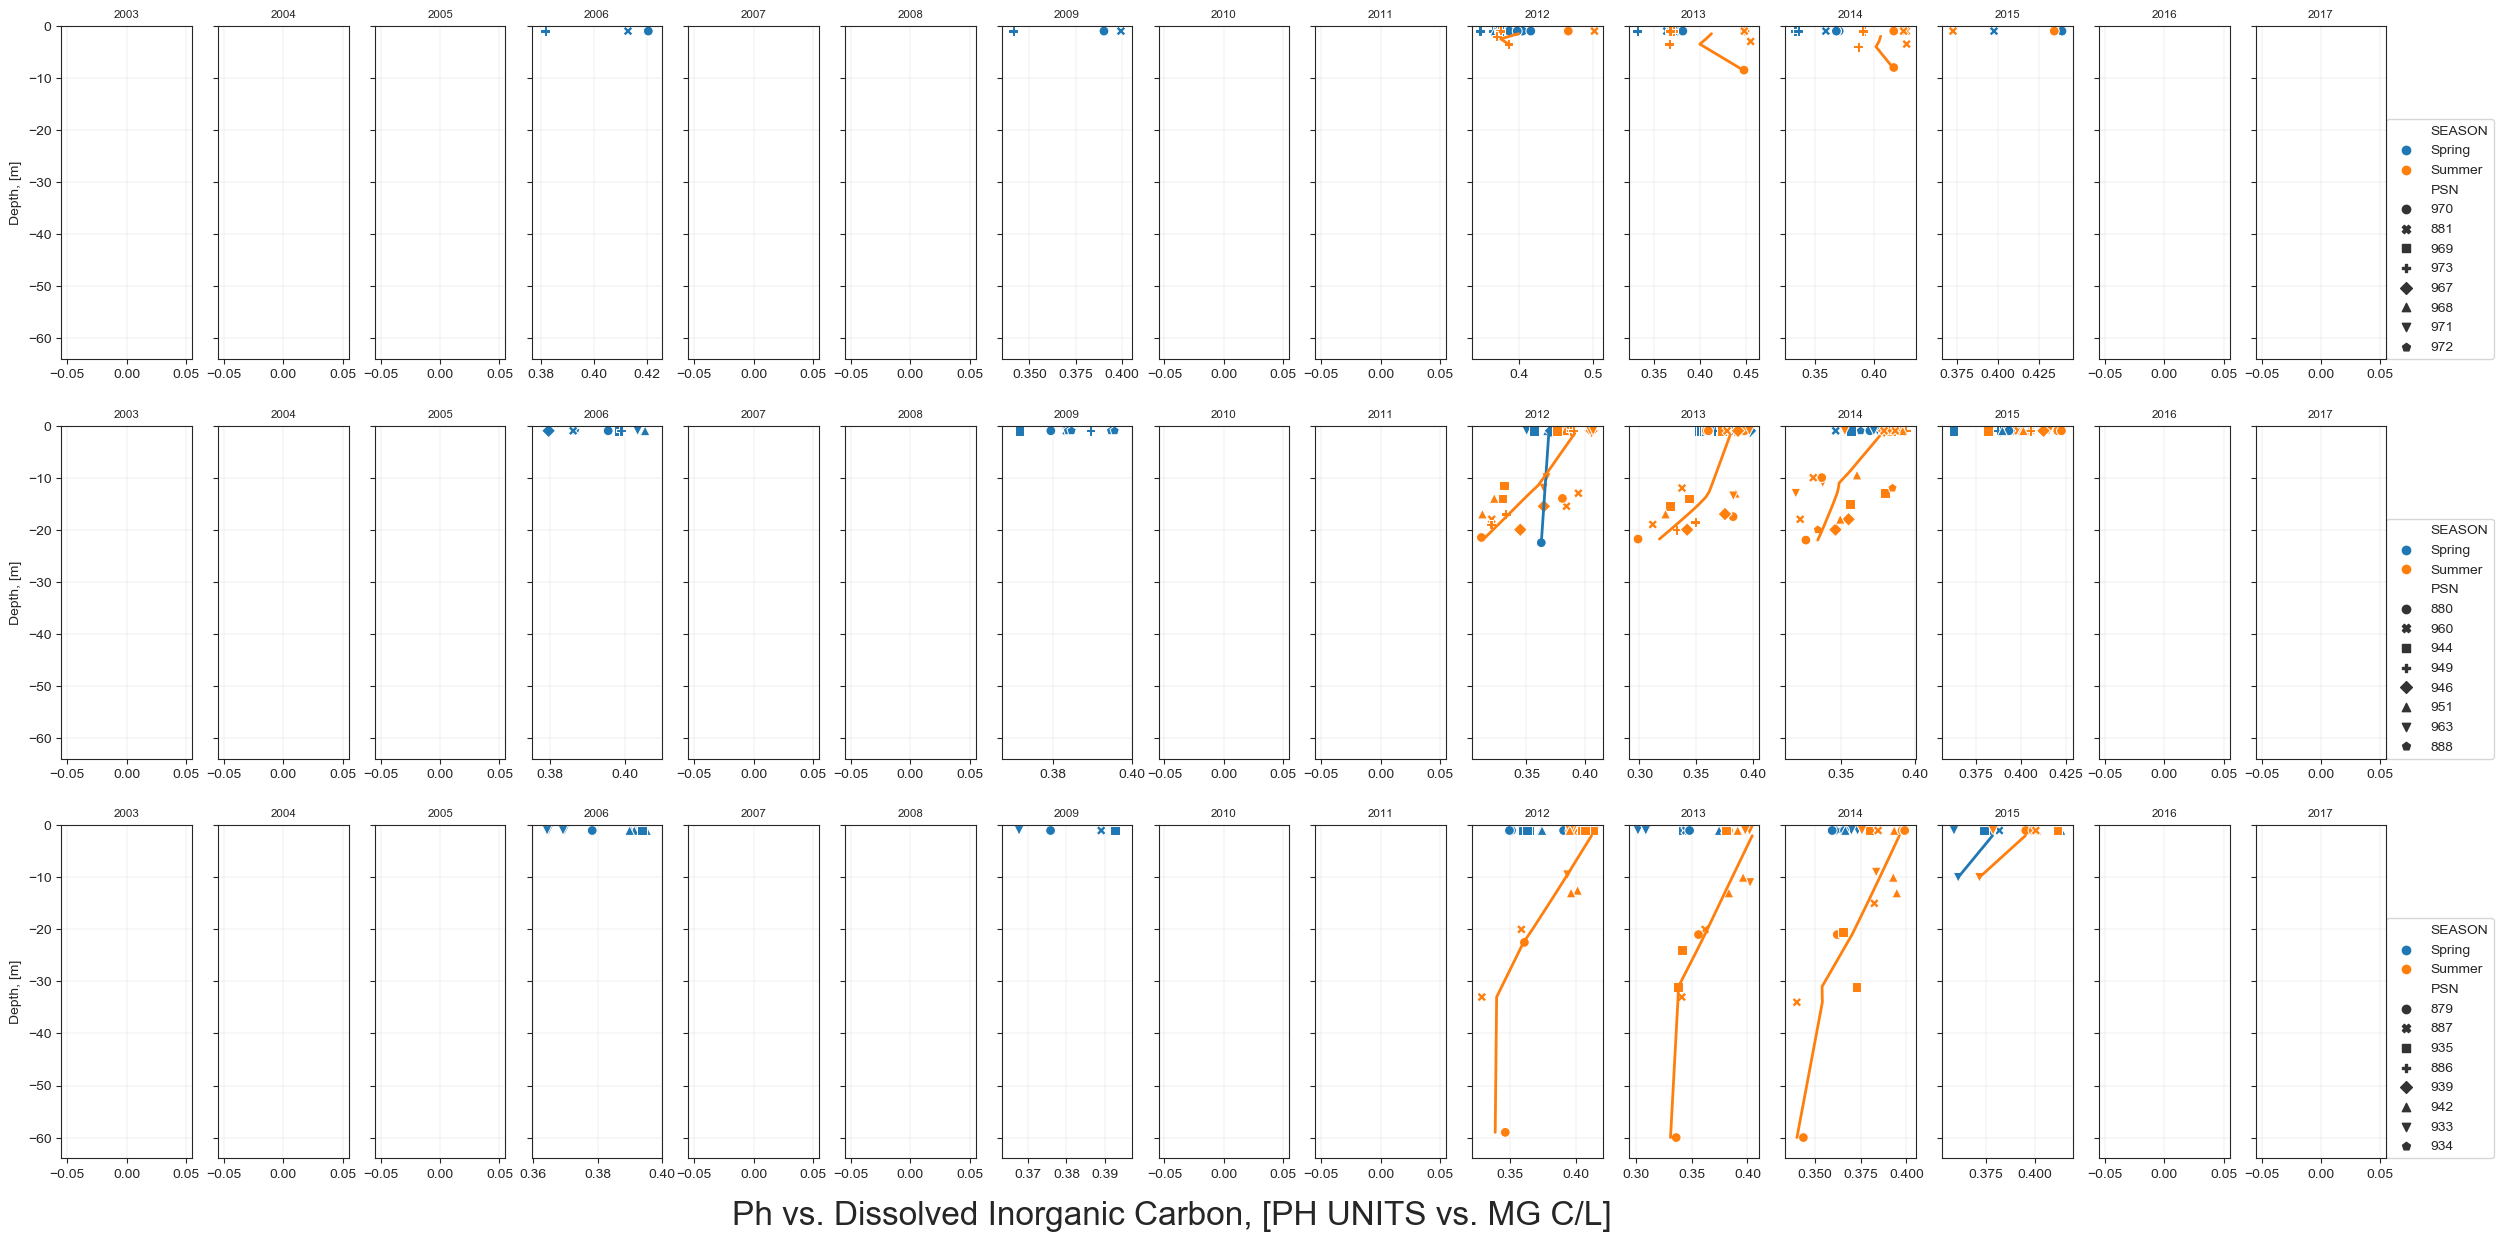

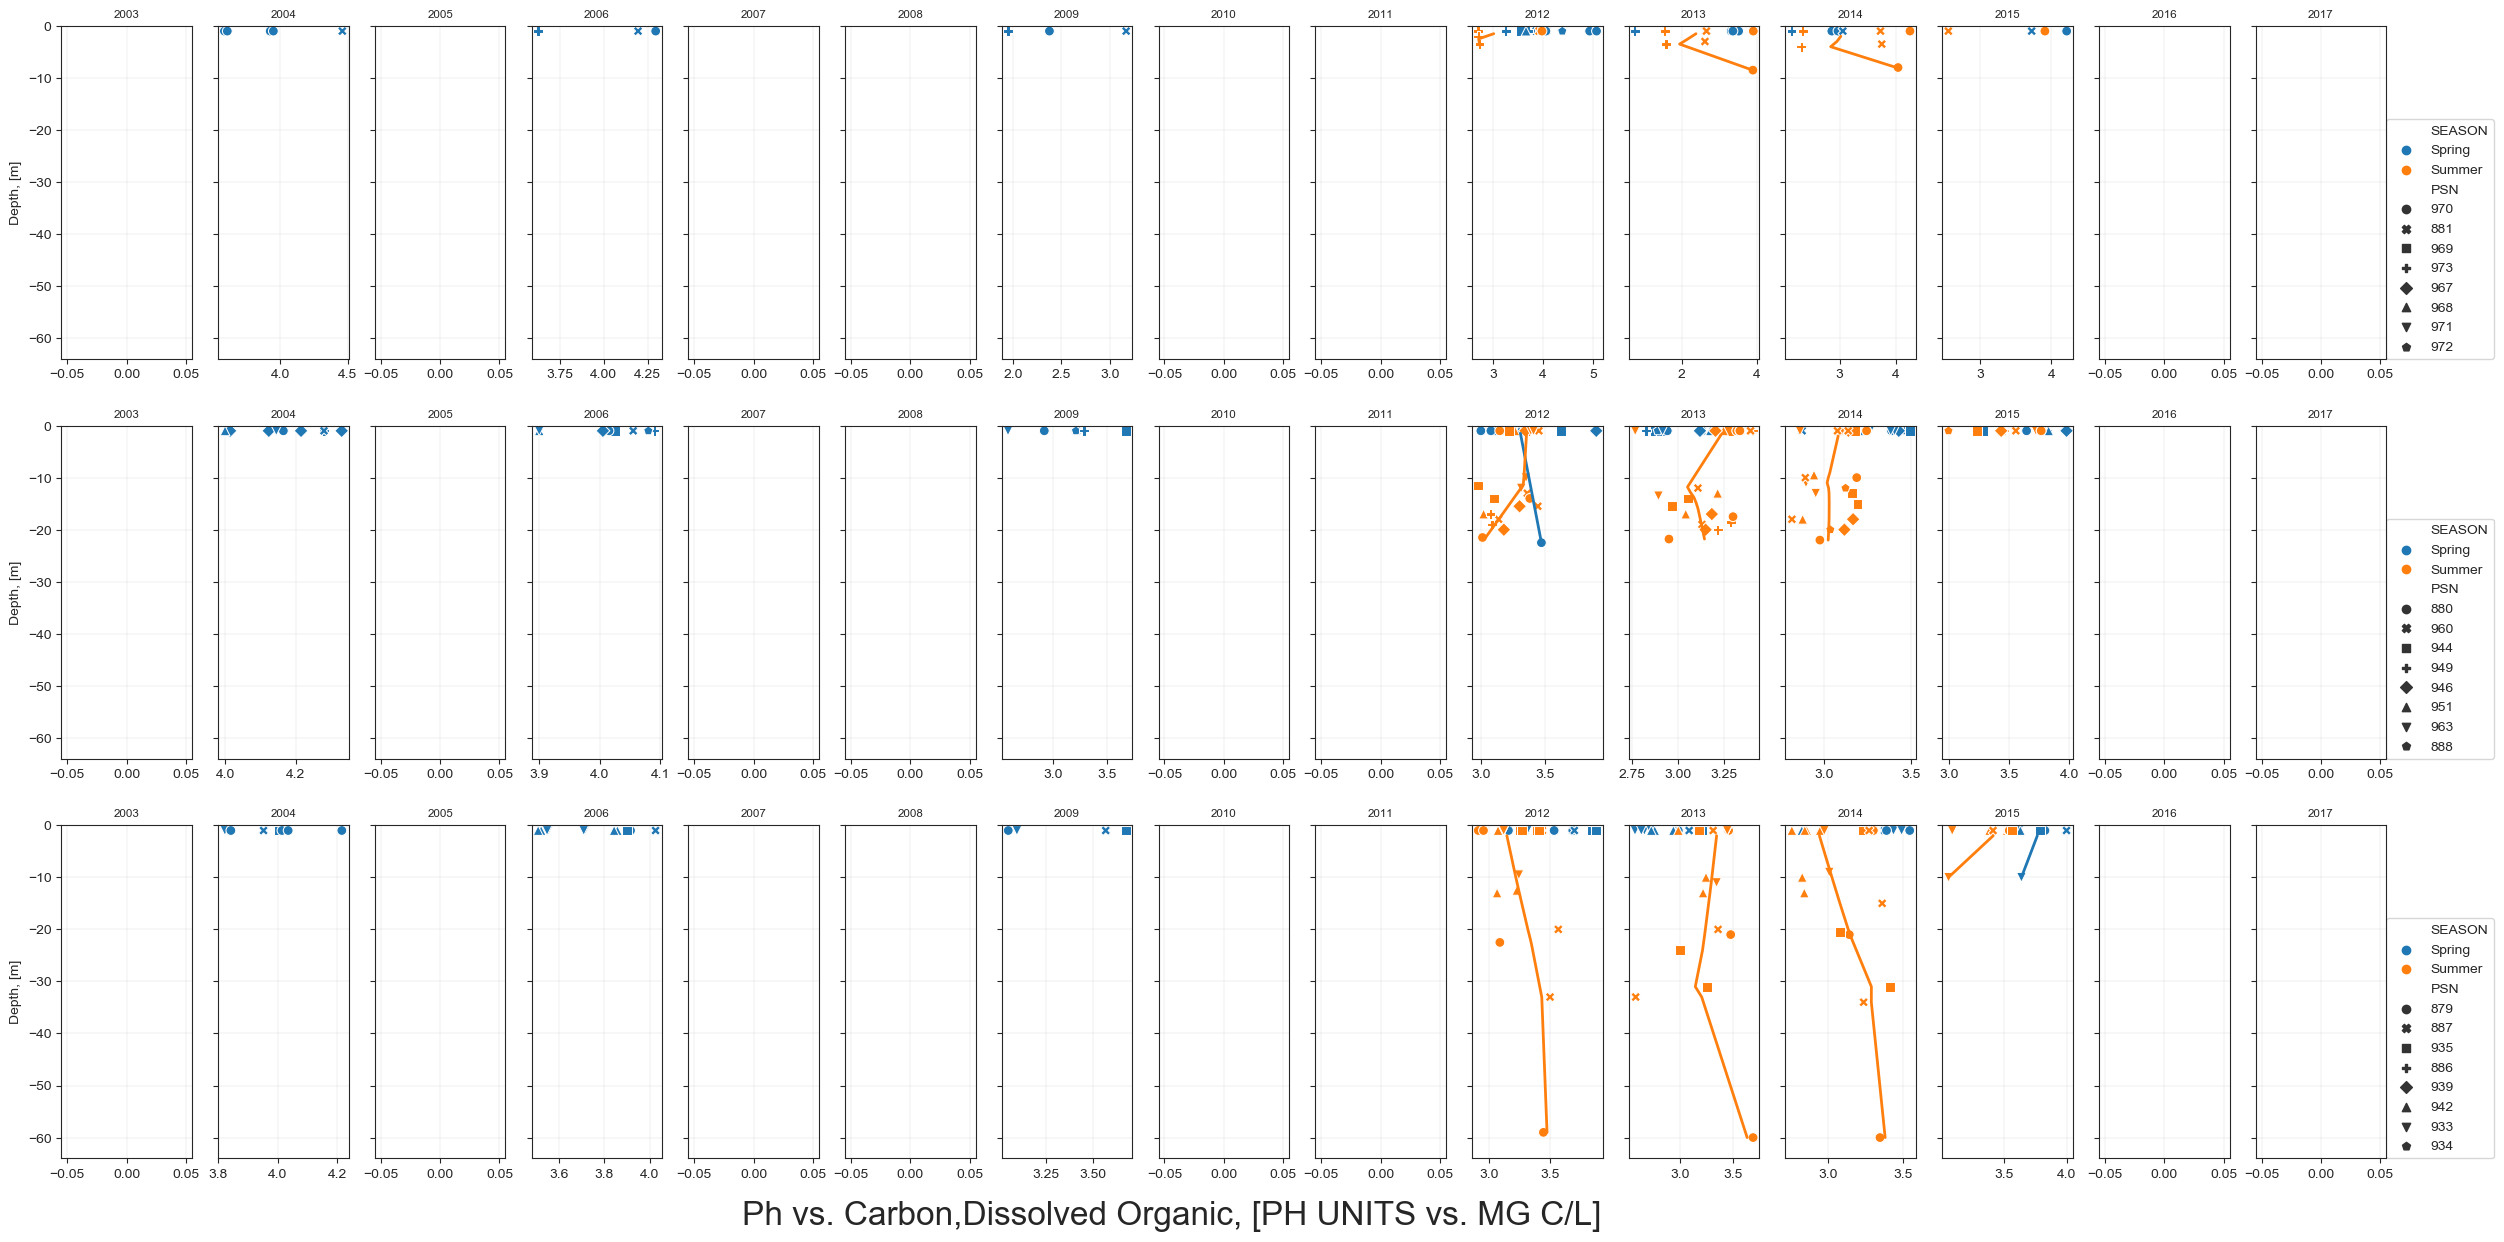

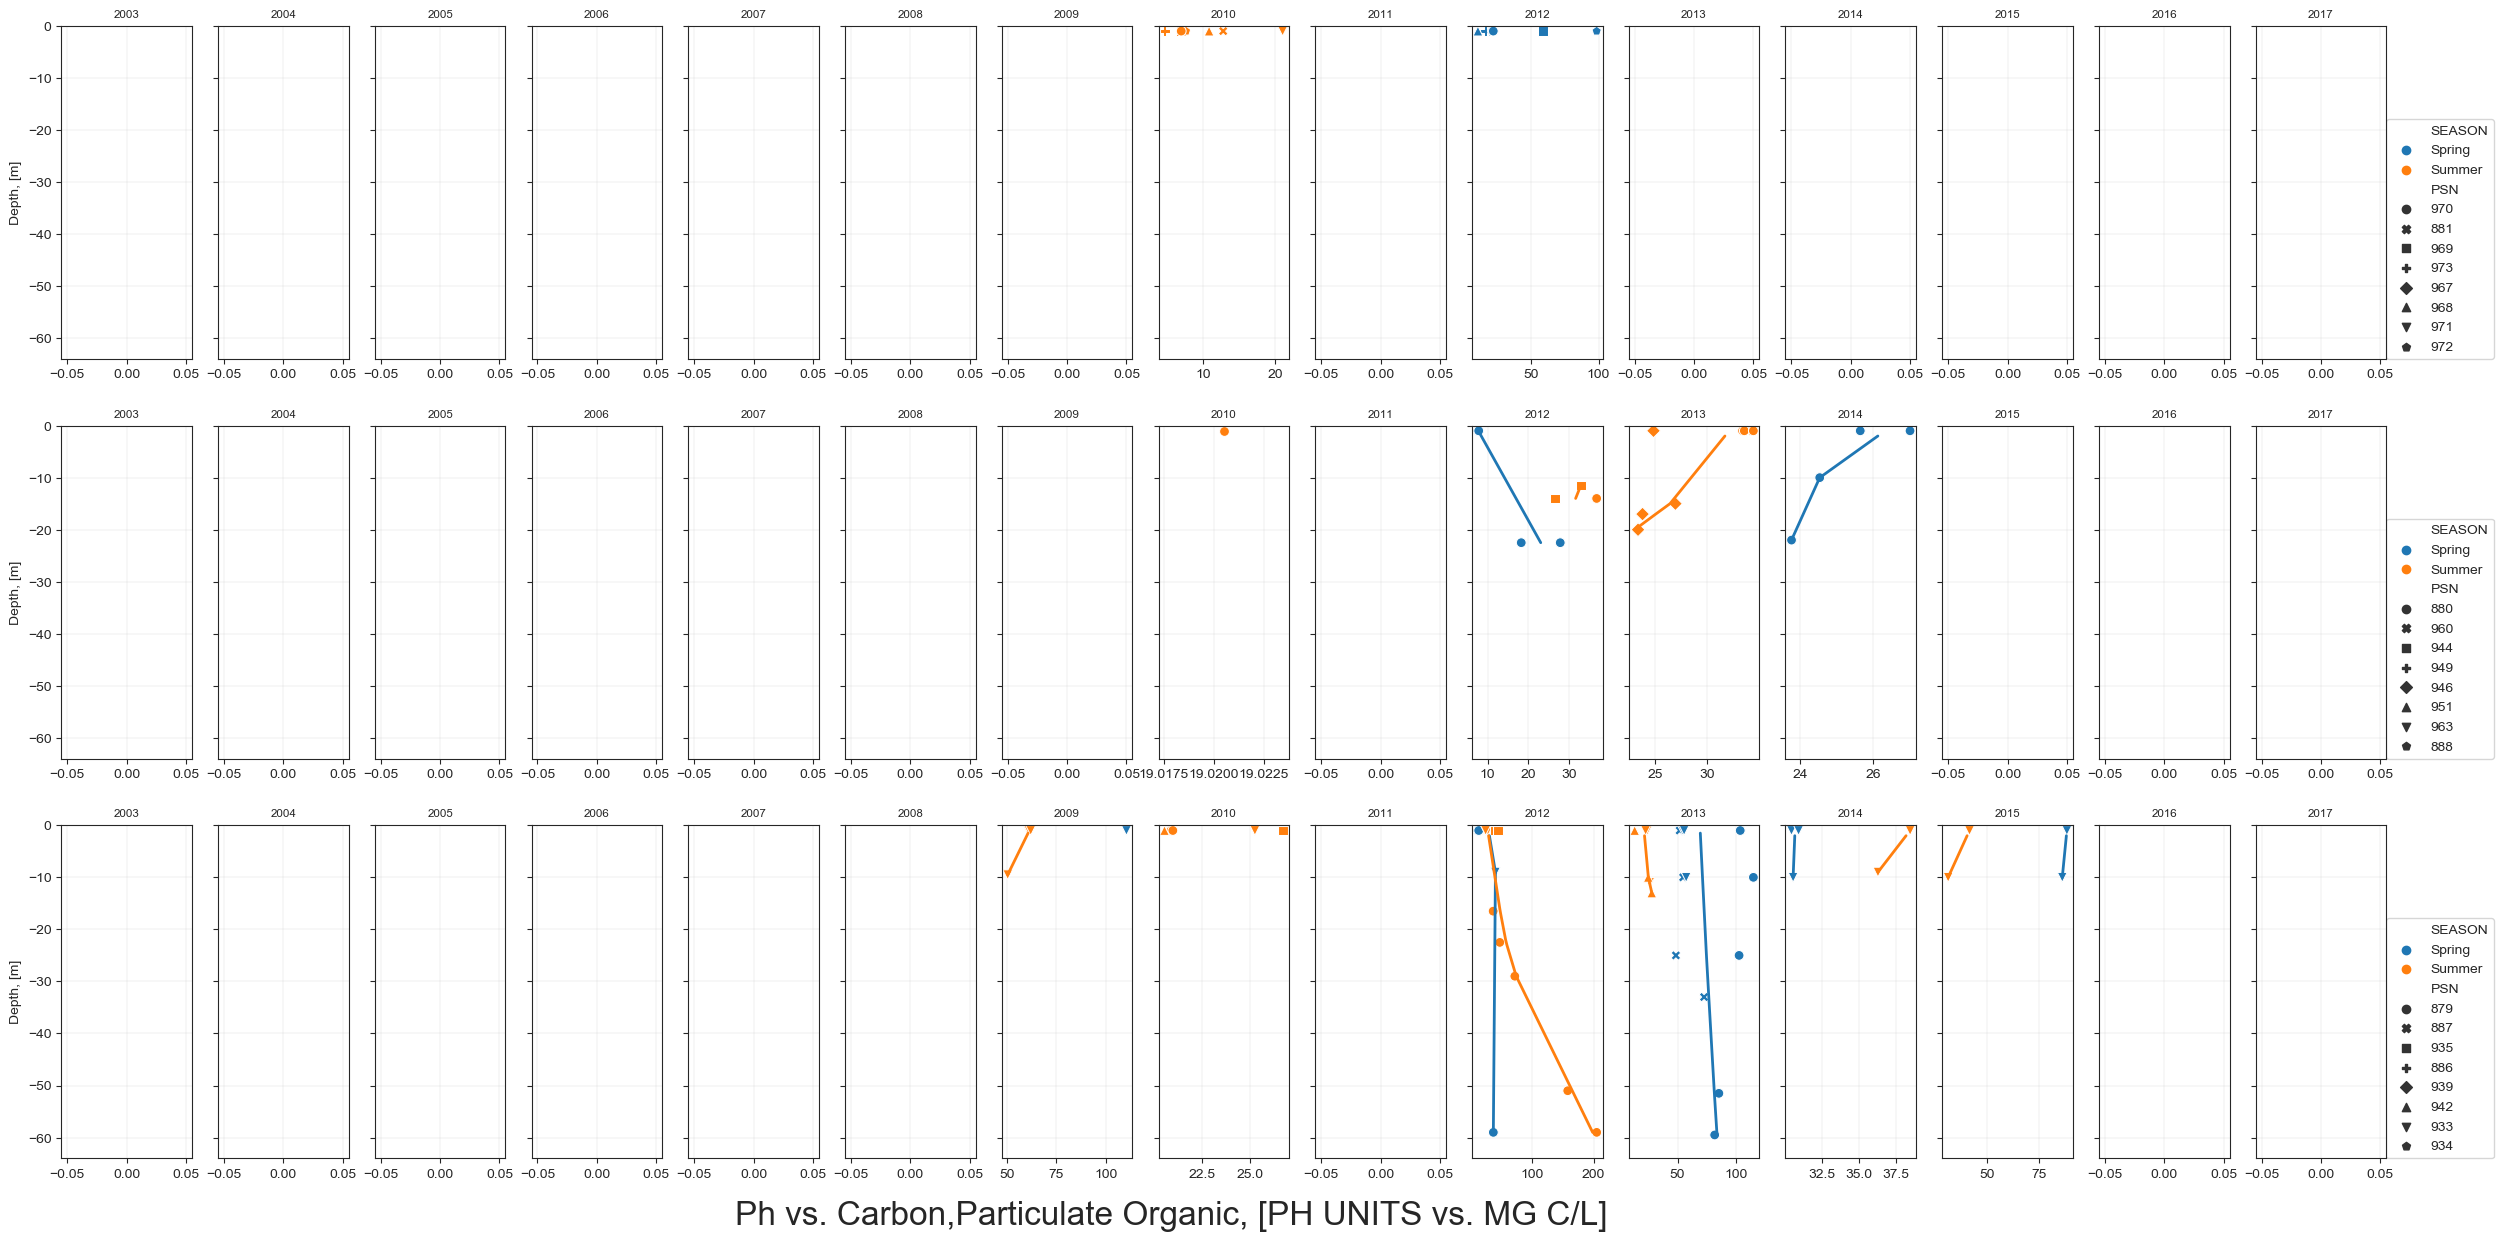

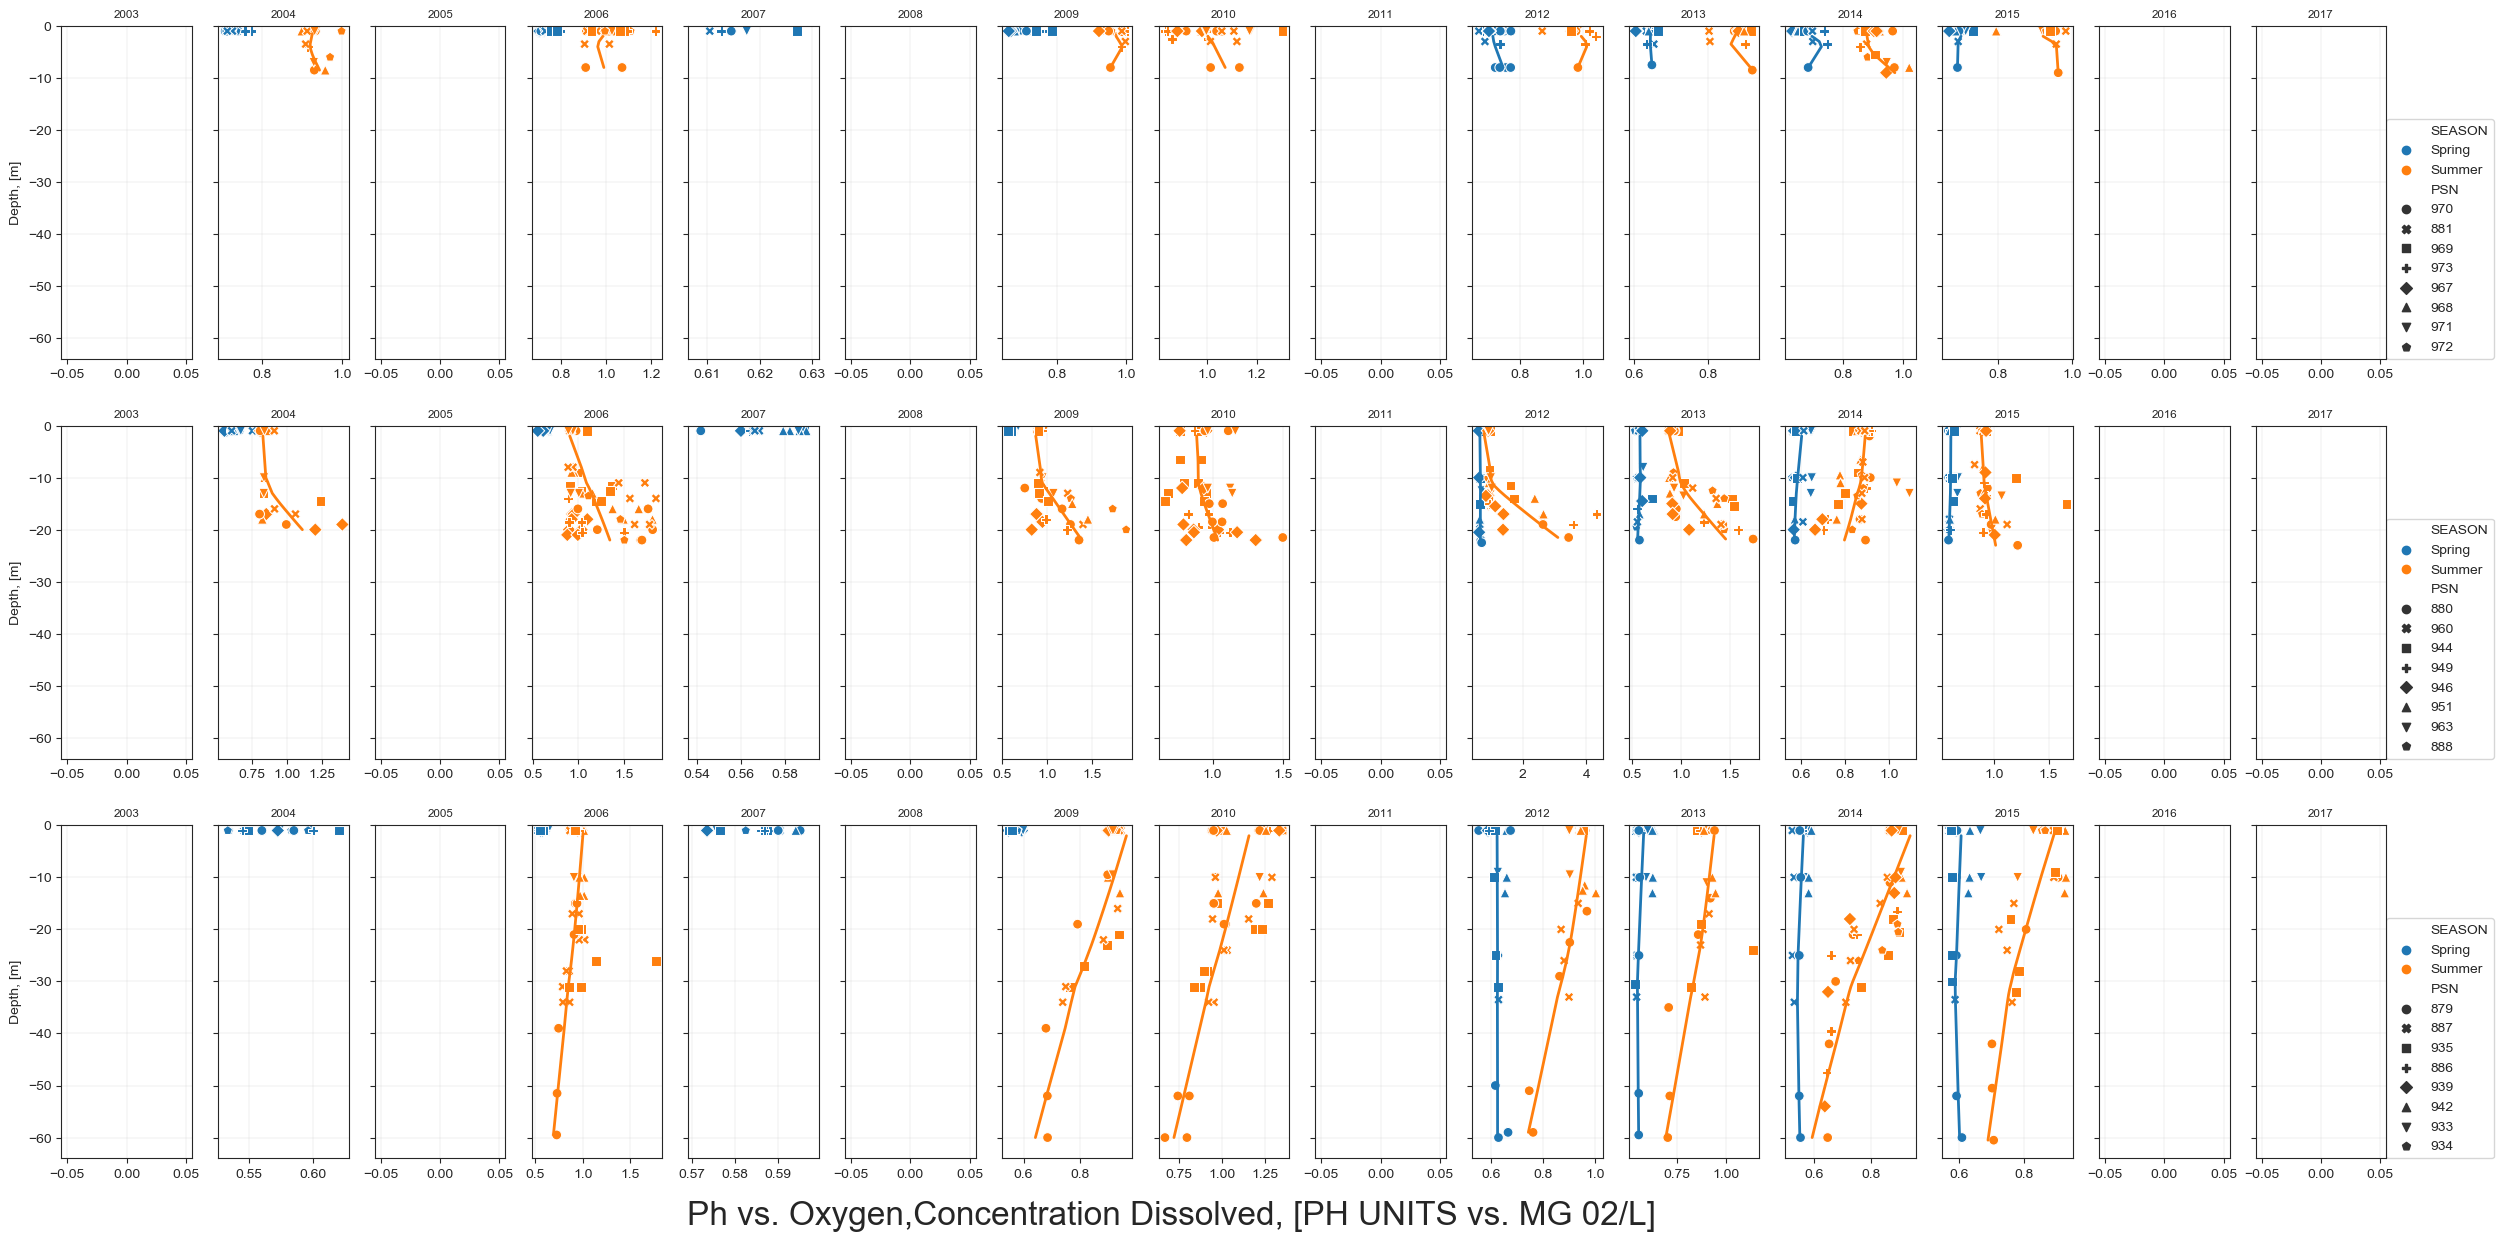

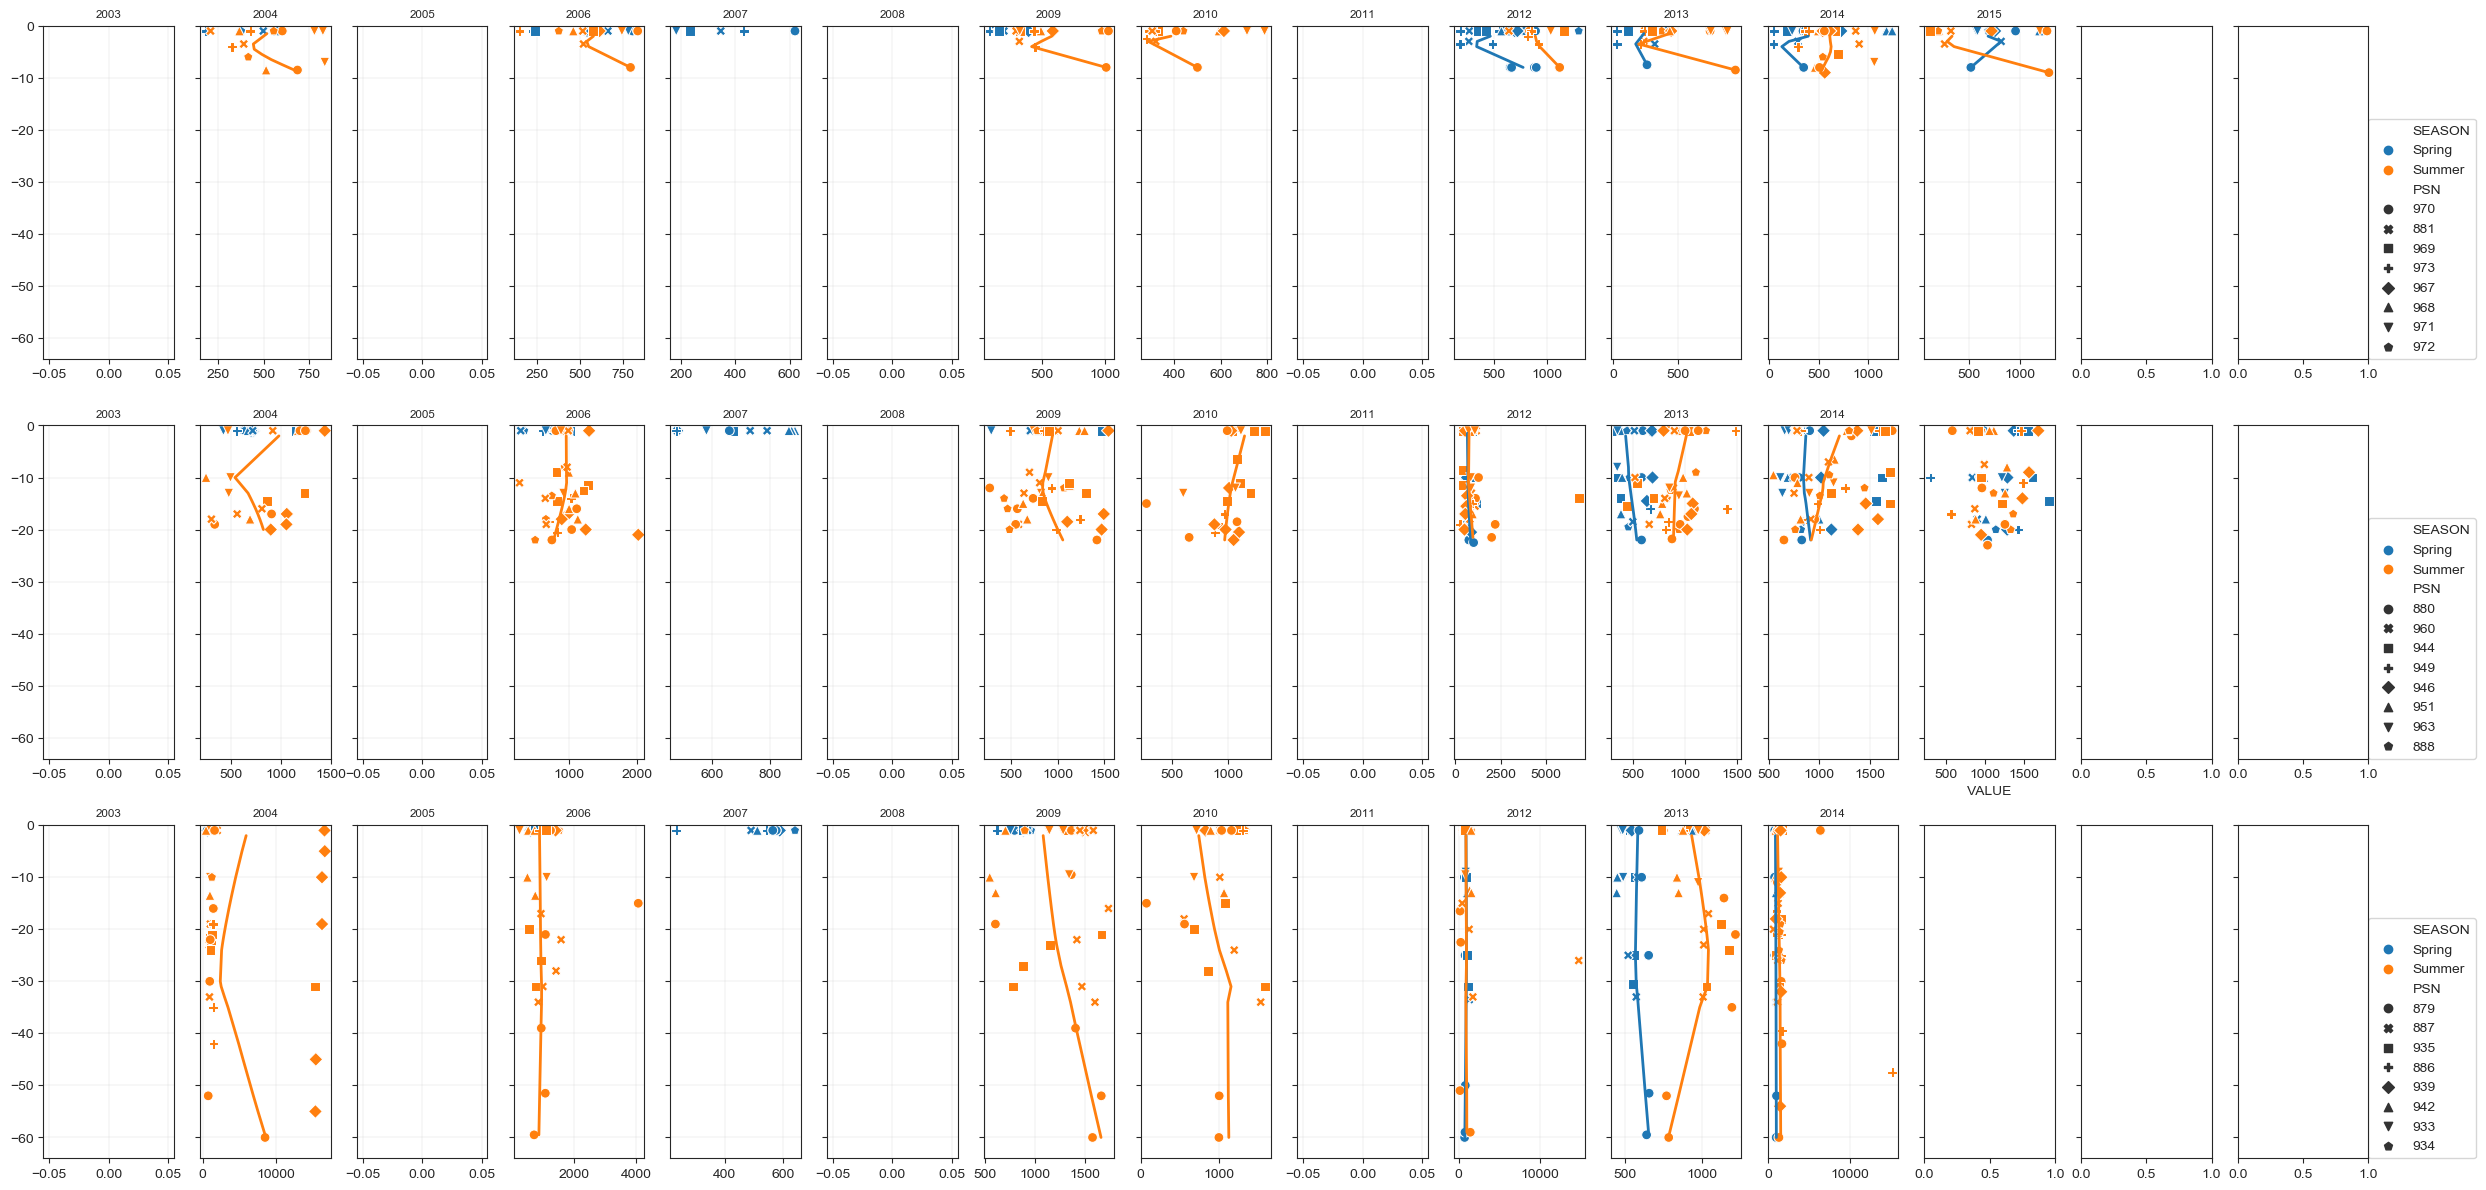

In [29]:
for a in combined_elements:
    elem_1 = ECCCmeas[ECCCmeas.ABBREV.isin(a)]
    for b in combined_elements:
        if a==b:
            pass
        else:
            elem_2 = ECCCmeas[ECCCmeas.ABBREV.isin(b)]
            Element = pd.merge(elem_1, elem_2, how='inner', on=['DEPTH_FROM', 'PSN', 'SEASON', 'YEAR'])
            Element['VALUE'] = Element['VALUE_x']/Element['VALUE_y']
            f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
            for j, y in enumerate(years):
                for i, b in enumerate([western_basin_f[:8], central_basin_f[:8], eastern_basin_f[:8]]):

                    sns_data = Element[(Element['PSN'].isin(b)) & (Element['YEAR']==y)]
                    g = sns.scatterplot(x='VALUE', y='DEPTH_FROM', data=sns_data, ax=axes[i][j], hue='SEASON', hue_order=seasons, style_order=b, style='PSN', s=50)


                    for k, s in enumerate(seasons):
                        data = sns_data[sns_data['SEASON']==s]
                        data = data.sort_values('DEPTH_FROM')
                        xold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['DEPTH_FROM'].values
                        yold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['VALUE'].values

            #             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
            #             unew = np.arange(0, 1.00, 0.1)
            #             out = interpolate.splev(unew, tck)
                        try:
                            # lowess will return our "smoothed" data with a y value for at every x-value
                            lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                            # unpack the lowess smoothed points to their values
                            lowess_x = list(zip(*lowess))[0]
                            lowess_y = list(zip(*lowess))[1]


                            tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                            unew = np.arange(xold.min(), xold.max(), 1)
                            out = tck(unew)

                            if s=='Spring':
                                clr=sns.color_palette().as_hex()[0]
                            if s=='Summer' or s=='Fall':
                                clr=sns.color_palette().as_hex()[1]
                #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=Elementr, edgecolor='w')
                #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                            axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
                        except:
                            pass
                        axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            #             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=Elementr)
            #             axes[i][j].set_xlim(0,30)
                        axes[i][j].set_ylim(-64,0)
                        axes[i][j].grid(lw=0.2)
                        axes[i][j].legend()
                        axes[i][j].legend_.remove()
                        if y==2012:
                            asns = g.get_legend_handles_labels()[0][:12]
                            axes[i][j].legend(handles=asns, loc=(7.,0))
                        axes[i][j].set_xlabel('')
                        axes[i][j].set_ylabel('')
#                         axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
            #             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
            #                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')


            # axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

            # axes[2][2].set_xlim(16,18)
            # axes[2][0].set_xlim(16,17.5)

            limits = []
            for line in axes:
                low = [a.get_xlim()[0] for a in line]
                high = [a.get_xlim()[1] for a in line]
                limits.append((min(low),max(high)))

            #     for i,ax in enumerate(axes[0]):
            #         axes[0][i].set_xlim(limits[0])
            #         axes[1][i].set_xlim(limits[1])
            #         axes[2][i].set_xlim(limits[2])



            axes[0][0].set_ylabel('Depth, [m]')
            axes[1][0].set_ylabel('Depth, [m]')
            axes[2][0].set_ylabel('Depth, [m]')
            try:
                axes[2][0].text(8.5,-0.2, Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+', ['+ Element.UNITS_x.values[0].strip()+' vs. '+ Element.UNITS_y.values[0].strip() +']', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
                f.savefig('Mass Balance/GLENDA/All Stations/ECCC Ratios/'+Element.FULL_NAME_y.values[0].strip()+'/'+Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+'_no_scales.pdf')
            except:
                pass



In [ ]:
for elem in combined_elements:
    Element = ECCCmeas[ECCCmeas.ABBREV.isin(elem)]
    f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
    for j, y in enumerate(years):
        for i, b in enumerate([western_basin_f[:8], central_basin_f[:8], eastern_basin_f[:8]]):

            sns_data = Element[(Element['PSN'].isin(b)) & (Element['YEAR']==y)]
            g=sns.scatterplot(x='VALUE', y='DEPTH_FROM', data=sns_data, ax=axes[i][j], hue='SEASON', hue_order=seasons, style_order=b, style='PSN', s=50)
                

            for k, s in enumerate(seasons):
                data = sns_data[sns_data['SEASON']==s]
                data = data.sort_values('DEPTH_FROM')
                xold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['DEPTH_FROM'].values
                yold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['VALUE'].values

    #             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
    #             unew = np.arange(0, 1.00, 0.1)
    #             out = interpolate.splev(unew, tck)
                try:
                    # lowess will return our "smoothed" data with a y value for at every x-value
                    lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                    # unpack the lowess smoothed points to their values
                    lowess_x = list(zip(*lowess))[0]
                    lowess_y = list(zip(*lowess))[1]


                    tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                    unew = np.arange(xold.min(), xold.max(), 1)
                    out = tck(unew)

                    if s=='Spring':
                        clr=sns.color_palette().as_hex()[0]
                    if s=='Summer' or s=='Fall':
                        clr=sns.color_palette().as_hex()[1]
        #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=Elementr, edgecolor='w')
        #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                    axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
                except:
                    pass
                axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
    #             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=Elementr)
    #             axes[i][j].set_xlim(0,30)
                axes[i][j].set_ylim(-64,0)
                axes[i][j].grid(lw=0.2)
                axes[i][j].legend()
                axes[i][j].legend_.remove()
                if y==2012:
                    asns = g.get_legend_handles_labels()[0][:12]
                    axes[i][j].legend(handles=asns, loc=(7.,0))
                axes[i][j].set_xlabel('')
                axes[i][j].set_ylabel('')
#                 axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
    #             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
    #                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')
    
#     asns = g.get_legend_handles_labels()[0][:12]
    
#     axes[0][12].legend(handles=asns, loc=(3.5,0))
#     axes[1][12].legend(handles=asns, loc=(3.5,0))
#     axes[2][12].legend(handles=asns, loc=(3.5,0))

    # axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

    # axes[2][2].set_xlim(16,18)
    # axes[2][0].set_xlim(16,17.5)

    limits = []
    for line in axes:
        low = [a.get_xlim()[0] for a in line]
        high = [a.get_xlim()[1] for a in line]
        limits.append((min(low),max(high)))

#     for i,ax in enumerate(axes[0]):
#         axes[0][i].set_xlim(limits[0])
#         axes[1][i].set_xlim(limits[1])
#         axes[2][i].set_xlim(limits[2])



    axes[0][0].set_ylabel('Depth, [m]')
    axes[1][0].set_ylabel('Depth, [m]')
    axes[2][0].set_ylabel('Depth, [m]')
    axes[2][0].text(8.5,-0.2, Element.FULL_NAME.values[0].title().strip()+', ['+ Element.UNITS.values[0].strip() +']', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
    f.savefig('Mass Balance/GLENDA/All Stations/ECCC top 8 stations with Mean LOESS/ECCC_Depth_Profiles_With_Mean_'+Element.FULL_NAME.values[0].title().strip()+'_no_scales.pdf')



In [ ]:
ECCCmeas.ABBREV.unique()

In [ ]:
for a in combined_elements:#ECCCmeas.ABBREV.unique():
    elem_1 = ECCCmeas[ECCCmeas.ABBREV.isin(a)]
    for b in combined_elements:#ECCCmeas.ABBREV.unique():
        if a==b:
            pass
        else:
            elem_2 = ECCCmeas[ECCCmeas.ABBREV.isin(b)]
            Element = pd.merge(elem_1, elem_2, how='inner', on=['DEPTH_FROM', 'PSN', 'SEASON', 'YEAR'])
            Element['VALUE'] = Element['VALUE_x']/Element['VALUE_y']
            f, axes = plt.subplots(3,15, figsize=(2*15,5*3), dpi=100, sharex=False, sharey=True)
            for j, y in enumerate(years):
                for i, b in enumerate([western_basin_f[:8], central_basin_f[:8], eastern_basin_f[:8]]):

                    sns_data = Element[(Element['PSN'].isin(b)) & (Element['YEAR']==y)]
                    if a==['PH'] and y==2013:
                        g=sns.scatterplot(x='VALUE', y='DEPTH_FROM', data=sns_data, ax=axes[i][j], hue='SEASON', hue_order=seasons, style_order=b, style='PSN', s=50)
                    sns.scatterplot(x='VALUE', y='DEPTH_FROM', data=sns_data, ax=axes[i][j], hue='SEASON', hue_order=seasons, style_order=b, style='PSN', s=50)


                    for k, s in enumerate(seasons):
                        data = sns_data[sns_data['SEASON']==s]
                        data = data.sort_values('DEPTH_FROM')
                        xold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['DEPTH_FROM'].values
                        yold = data.groupby('DEPTH_FROM').mean()['VALUE'].reset_index()['VALUE'].values

            #             tck,u  = interpolate.splprep([xold,yold], s=50000000000)
            #             unew = np.arange(0, 1.00, 0.1)
            #             out = interpolate.splev(unew, tck)
                        try:
                            # lowess will return our "smoothed" data with a y value for at every x-value
                            lowess = sm.nonparametric.lowess(yold, xold, frac=1)

                            # unpack the lowess smoothed points to their values
                            lowess_x = list(zip(*lowess))[0]
                            lowess_y = list(zip(*lowess))[1]


                            tck = interpolate.interp1d(lowess_x, lowess_y, kind='linear')
                            unew = np.arange(xold.min(), xold.max(), 1)
                            out = tck(unew)

                            if s=='Spring':
                                clr=sns.color_palette().as_hex()[0]
                            if s=='Summer' or s=='Fall':
                                clr=sns.color_palette().as_hex()[1]
                #             axes[i][j].scatter(data.VALUE_1, -data.SAMPLE_DEPTH_M, c=Elementr, edgecolor='w')
                #             sns_data.loc[:,'SAMPLE_DEPTH_M'] *= -1

                            axes[i][j].plot(out, unew, c=clr, lw=2,zorder=1)
                        except:
                            pass
                        axes[i][j].set_title(" ".join([str(y)]), fontsize='small')
            #             axes[i][j].fill_betweenx(-data['z'], data['val']['mean']-data['val']['std'], data['val']['mean']+data['val']['std'], alpha=0.5, lw=0., color=Elementr)
            #             axes[i][j].set_xlim(0,30)
                        axes[i][j].set_ylim(-64,0)
                        axes[i][j].grid(lw=0.2)
                        axes[i][j].legend()
                        axes[i][j].legend_.remove()
                        axes[i][j].set_xlabel('')
                        axes[i][j].set_ylabel('')
#                         axes[i][j].set_xlim(np.floor(axes[i][j].get_xlim()[0]), np.ceil(axes[i][j].get_xlim()[1]))
            #             for c,st in zip(sns.color_palette().as_hex()[:len(b)],b):
            #                 axes[i][j].plot(data[data['STATION_ID']==st].VALUE_1, data[data['STATION_ID']==st].SAMPLE_DEPTH_M,c=c, lw=0.3, label='')

            asns = g.get_legend_handles_labels()[0][:12]

            axes[0][12].legend(handles=asns, loc=(3.5,0))
            axes[1][12].legend(handles=asns, loc=(3.5,0))
            axes[2][12].legend(handles=asns, loc=(3.5,0))

            # axes[0][0].text(130,10, 'Chloride concnetrations, [mg/L]', fontsize=24)

            # axes[2][2].set_xlim(16,18)
            # axes[2][0].set_xlim(16,17.5)

            limits = []
            for line in axes:
                low = [a.get_xlim()[0] for a in line]
                high = [a.get_xlim()[1] for a in line]
                limits.append((min(low),max(high)))

            #     for i,ax in enumerate(axes[0]):
            #         axes[0][i].set_xlim(limits[0])
            #         axes[1][i].set_xlim(limits[1])
            #         axes[2][i].set_xlim(limits[2])



            axes[0][0].set_ylabel('Depth, [m]')
            axes[1][0].set_ylabel('Depth, [m]')
            axes[2][0].set_ylabel('Depth, [m]')
            try:
                axes[2][0].text(8.5,-0.2, Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+', ['+ Element.UNITS_x.values[0].strip()+' vs. '+ Element.UNITS_y.values[0].strip() +']', fontsize=24, horizontalalignment='center', transform=axes[2][0].transAxes)
                f.savefig('Mass Balance/GLENDA/All Stations/ECCC Ratios/'+Element.FULL_NAME_y.values[0].strip()+'/'+Element.FULL_NAME_x.values[0].title().strip()+' vs. '+Element.FULL_NAME_y.values[0].title().strip()+'_no_scales.pdf')
            except:
                pass



In [ ]:
elem_1 = ECCCmeas[ECCCmeas.ABBREV==a]

In [ ]:
elem_2 = ECCCmeas[ECCCmeas.ABBREV==b]

In [ ]:
Ratios = pd.merge(elem_1, elem_2, how='inner', on=['DEPTH_FROM', 'PSN', 'SEASON', 'YEAR'])
Ratios['VALUE'] = Ratios['VALUE_x']/Ratios['VALUE_y']


In [ ]:
Ratios['VALUE'] = Ratios['VALUE_x']/Ratios['VALUE_y']

In [ ]:
Ratios.shape

In [ ]:
elem_1.shape

In [ ]:
import os
for directory in ECCCmeas.FULL_NAME.unique():
    directory = directory.strip()
    if not os.path.exists('/Users/imarkelo/git/Great-Lakes-Data/post_proc_scripts/Mass Balance/Mass Balance/GLENDA/All Stations/ECCC Ratios/'+directory):
        os.makedirs('/Users/imarkelo/git/Great-Lakes-Data/post_proc_scripts/Mass Balance/Mass Balance/GLENDA/All Stations/ECCC Ratios/'+directory)